IA & Data science (LU3IN0226) -- 2020-2021
--------
*&copy; Equipe pédagogique: Vincent Guigue, Christophe Marsala, Edoardo Sarti, Olivier Schwander.*


# TD-TME07: les arbres de décision (version numérique)

L'objectif de ce notebook est d'implémenter une version de l'algorithme d'apprentissage supervisé par arbre de décision qui travaille sur des données numériques.


## Préparation du notebook

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

*Double-cliquer ici et insérer les noms et prénoms de votre binôme*

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-07</tt> et rajouter à la suite de <tt>tme-07</tt> les noms des membres du binômes séparés par un tiret.

Par exemple, pour le binôme Luke Skywalker et Han Solo, le nom de fichier devient `tme-07-Skywalker-Solo`

Penser à sauvegarder fréquemment le fichier en cours de travail :
- soit en cliquant sur l'icône "disquette"
- soit par la combinaison de touches [Ctrl]-S

<font color="RED" size="+1">**[Q]**</font> **Mise à jour de la librairie `iads`**

En premier lieu, vérifier que votre librairie `iads` est bien à jour : 
- dans le fichier `Classifieurs.py`: tous les classifieurs que vous avez implémentés depuis le début des séances. Rajouter aussi dans ce fichier la fonction `leave_one_out` écrite dans le notebook précédent.

Une fois à jour, importer la librairie pour pouvoir l'utiliser dans ce notebook.


In [1]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

Afin de réaliser les premiers essais avec les fonctions que l'on va programmer, on charge la base des iris de Fisher que l'on a vue dans le cours 6 (voir aussi par exemple : https://fr.wikipedia.org/wiki/Iris_de_Fisher) dont les exemples sont décrits par 4 variables et sont associés à l'une des 3 classes possibles ('setosa', 'virginica' et 'versicolor'). La classe est donnée dans la colonne 'species' du dataframe chargé de la façon suivante:

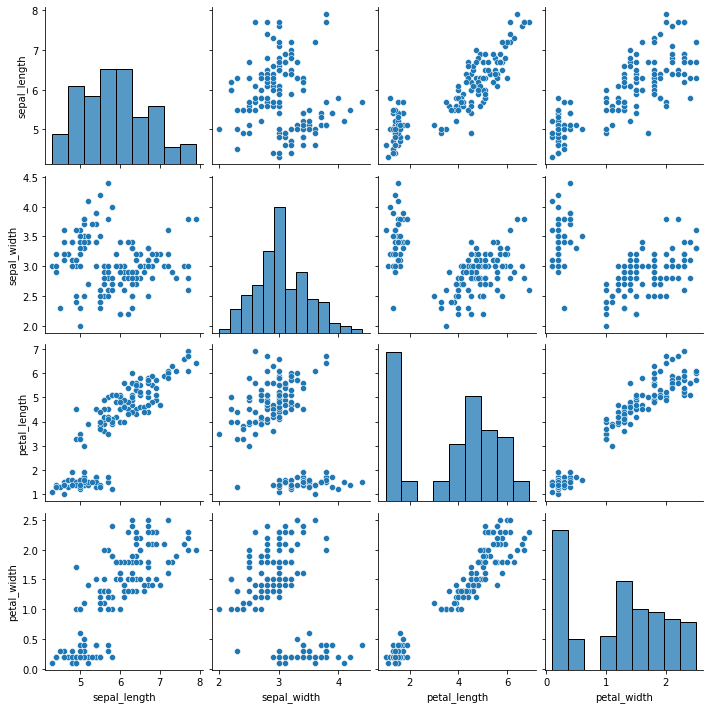

In [3]:
# Importation du package seaborn:
import seaborn as sns

# Le dataset des iris est fourni dans le package seaborn, on l'obtient ainsi:
iris_df = sns.load_dataset('iris')

# On peut alors construire le corrélogramme de ce dataset:
sns.pairplot(iris_df)

In [4]:
# Contenu du dataframe :
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [5]:
# Passer du dataframe à des arrays:
iris_desc = np.array(iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
iris_label = np.array(iris_df['species'])

# obtenir les noms des colonnes :
iris_noms = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

print("Noms des features: ",iris_noms)

Noms des features:  ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [6]:
# Les 6 premières lignes du dataset:
iris_desc[0:6,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4]])

In [7]:
iris_label[0:6]

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa'],
      dtype=object)

In [8]:
# Exemple : fleurs dont la 'sepal_length' vaut 6.3
iris_label[iris_desc[:,0] == 6.3]

array(['versicolor', 'versicolor', 'versicolor', 'virginica', 'virginica',
       'virginica', 'virginica', 'virginica', 'virginica'], dtype=object)

### Entropie et gain d'information

On utile ici la fonction de calcul de l'entropie de Shannon implémentée dans le TDTME-06. Si ce n'est pas encore fait, pensez à ajouter la fonction `shannon` de ce TDTME-06 dans votre fichier `utils.py`de votre librairie `iads`.

<font color="RED" size="+1">**[Q]**</font> Vérifier que tout fonction pour la fonction `shannon`.

In [13]:
# Exemples d'utilisation:
print("H([1]) = ", ut.shannon([1]))
print("H([1,0]) = ", ut.shannon([1, 0]))
print("H([0.25, 0.25, 0.25, 0.25]) = ", ut.shannon([0.25, 0.25, 0.25, 0.25]))
print("H([0.7, 0.1, 0.2, 0.0]) = ", ut.shannon([0.7, 0.1, 0.2, 0.0]))
print("H([1.0/3, 2.0/3]) = ", ut.shannon([1.0/3, 2.0/3]))

H([1]) =  0.0
H([1,0]) =  0.0
H([0.25, 0.25, 0.25, 0.25]) =  1.0
H([0.7, 0.1, 0.2, 0.0]) =  0.5783898247235197
H([1.0/3, 2.0/3]) =  0.9182958340544896


<font color="RED" size="+1">**[Q]**</font> Vérifier que la fonction <code>entropie</code>  a aussi bien été mise dans `utils.py`.

In [14]:
# Exemple sur nos données :
ut.entropie(iris_label)

1.0

### Discrétisation des attributs numériques

Discrétiser un attribut numérique consiste en trouver un seuil de coupure dans son ensemble de valeurs. 

Par exemple, soit l'attribut Age contenant les valeurs 17, 18, 20, 27, 35, 37, 40. On discrétise cet attribut en 2 valeurs en prenant, par exemple, le seuil 30: cela permet de séparer d'un côté les valeurs inférieures ou égales à 30, et de l'autre les valeurs strictement supérieures à 30.

Le seuil est choisi afin d'optimiser la distribution des classes des exemples qui se trouvent de chaque côté du seuil. Une fois un seuil choisi, on calcule le désordre des classes associées aux exemples de chaque côté du seuil et on agrège les 2 valeurs de désordre obtenues pour déterminer la qualité de la coupure à l'aide de la mesure $Q$ vue en cours.


Soit $X$ un ensemble d'exemples, et soit $A$ un attribut que l'on souhaite discrétiser. Pour cela, on constitue l'ensemble des valeurs prises par les exemples de $X$ pour l'attribut $A$. Soit $A_X$ cet ensemble de valeurs.

La discrétisation de $A_X$ s'effectue par les étapes suivantes:
- Etape 1: ordonner de façon croissante les valeurs de $A_X$;
- Etape 2: regarder tous les seuils possibles de coupure entre 2 valeurs consécutives de $A_X$ (on prend comme seuil de coupure la valeur médiane entre ces 2 valeurs). Chaque seuil trouvé créé 2 intervalles qui générent 2 sous-ensembles de $X$: l'ensemble $X_1$ des exemples dont la valeur pour $A$ et inférieure ou égale au seuil, et l'ensemble $X_2$ des exemples dont la valeur pour $A$ et supérieure au seuil. On détermine la qualité du seuil par la mesure de qualité d'un test vue en cours. On note $Q(seuil)$ cette valeur.


La meilleure coupure pour discrétiser $A_X$ est celle qui minimise la valeur $Q(seuil)$.


Par exemple, soit $X=\{17, 18, 20, 27, 35, 37, 40\}$, chaque valeur étant associées aux classes +1, +1, -1, -1, +1, +1, -1 respectivement. Un seuil de coupure possible est $31$ ($31 = \frac{27+35}{2}$). Ce seuil coupe $X$ en $X_1=\{17, 18, 20, 27\}$ et $X_2=\{35, 37, 40\}$.

- pour $X_1$, la probabilité de chaque classe est: $p(+1)= 0.5$ et $p(-1)=0.5$ donc, $H_S(X_1)=1$;
- pour $X_2$, la probabilité de chaque classe est: $p(+1)= \frac{2}{3}$ et $p(-1)=\frac{1}{3}$ donc, $H_S(X_2)=0.9182958340544896$;
- on a donc: $$Q(seuil=31) = \frac{4}{7} H_S(X_1) + \frac{3}{7} H_S(X_2);$$
soit $Q(seuil=31) = 0.9182958340544896$

In [18]:
def discretise(desc, labels, col):
    """ array * array * int -> tuple[float, float]
        Hypothèse: les 2 arrays sont de même taille et contiennent au moins 2 éléments
        col est le numéro de colonne à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation: (import sys doit avoir été fait)
    min_entropie = sys.float_info.max  # on met à une valeur max car on veut minimiser 
    min_seuil = 0.0     
    
    # trie des valeurs: ind contient les indices dans l'ordre croissant des valeurs pour chaque colonne
    ind= np.argsort(desc,axis=0)
    
    # pour voir ce qui se passe, on va sauver les entropies trouvées et les points de coupures:
    liste_entropies = []
    liste_coupures = []
    
    # Dictionnaire pour compter les valeurs de classes qui restera à voir
    Avenir_nb_class = dict()
    # et son initialisation: 
    for j in range(0,len(desc)):
        if labels[j] in Avenir_nb_class:
            Avenir_nb_class[labels[j]] += 1
        else:
            Avenir_nb_class[labels[j]] = 1
    
    # Dictionnaire pour compter les valeurs de classes que l'on a déjà vues
    Vues_nb_class = dict()
    
    # Nombre total d'exemples à traiter:
    nb_total = 0  
    for c in Avenir_nb_class:
        nb_total += Avenir_nb_class[c]
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(desc)-1):
        v_ind_i = ind[i]   # vecteur d'indices de la valeur courante à traiter
        courant = desc[v_ind_i[col]][col]  # valeur courante de la colonne
        lookahead = desc[ind[i+1][col]][col] # valeur suivante de la valeur courante
        val_seuil = (courant + lookahead) / 2.0; # Seuil de coupure: entre les 2 valeurs
        
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if labels[v_ind_i[col]] in Vues_nb_class:
            Vues_nb_class[labels[v_ind_i[col]]] += 1
            
        else:
            Vues_nb_class[labels[v_ind_i[col]]] = 1
        # on retire de l'avenir:
        Avenir_nb_class[labels[v_ind_i[col]]] -= 1
        
        # construction de 2 listes: ordonnées sur les mêmes valeurs de classes
        # contenant le nb d'éléments de chaque classe
        nb_inf = [] 
        nb_sup = []
        tot_inf = 0
        tot_sup = 0
        for (c, nb_c) in Avenir_nb_class.items():
            nb_sup.append(nb_c)
            tot_sup += nb_c
            if (c in Vues_nb_class):
                nb_inf.append(Vues_nb_class[c])
                tot_inf += Vues_nb_class[c]
            else:
                nb_inf.append(0)
        
        # calcul de la distribution des classes de chaque côté du seuil:
        freq_inf = [nb/float(tot_inf) for nb in nb_inf]
        freq_sup = [nb/float(tot_sup) for nb in nb_sup]
        # calcul de l'entropie de la coupure
        val_entropie_inf = ut.shannon(freq_inf)
        val_entropie_sup = ut.shannon(freq_sup)
        
        val_entropie = (tot_inf / float(tot_inf+tot_sup)) * val_entropie_inf \
                       + (tot_sup / float(tot_inf+tot_sup)) * val_entropie_sup
        # Ajout de la valeur trouvée pour l'historique:
        liste_entropies.append(val_entropie)
        liste_coupures.append(val_seuil)
        
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie), (liste_coupures,liste_entropies,)

In [19]:
# Exemple d'utilisation:
numero_colonne = 0
resultat, liste_vals = discretise(iris_desc,iris_label,numero_colonne)

print("Seuil de coupure trouvé: ",resultat[0]," et son entropie:", resultat[1])

Seuil de coupure trouvé:  5.5  et son entropie: 0.6233117068221675


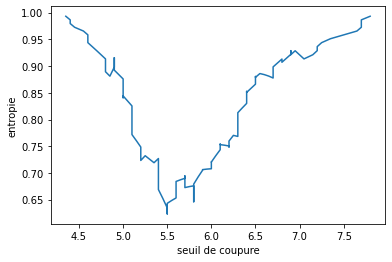

In [20]:
# Pour plot, on a besoin de la librairie suivante:
import matplotlib.pyplot as plt

# affichage de la variation de l'entropie en fonction du choix du seuil:
X,Y = liste_vals
plt.plot(X,Y)
plt.ylabel('entropie')
plt.xlabel('seuil de coupure')
plt.show()

Seuil de coupure trouvé:  0.8  et son entropie: 0.42061983571430495


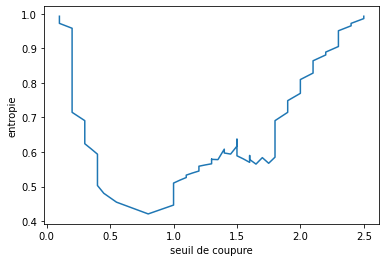

In [21]:
# Autre exemple:
numero_colonne = 3

resultat, liste_vals = discretise(iris_desc,iris_label,numero_colonne)

print("Seuil de coupure trouvé: ",resultat[0]," et son entropie:", resultat[1])
# affichage de la variation de l'entropie en fonction du choix du seuil:
X,Y = liste_vals
plt.plot(X,Y)
plt.ylabel('entropie')
plt.xlabel('seuil de coupure')
plt.show()

## Arbres de décision numériques

En utilisant la fonction `discretise`, modifier la fonction `construit_ad` réalisée au TDMTE précédent afin de pouvoir construire des arbres de décision avec des valeurs numériques.
Les attributs numériques seront discrétisés en 2 valeurs catégorielles.